In [131]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import distance
import re

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc

from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier


from imblearn.over_sampling import RandomOverSampler
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix, recall_score, precision_score, classification_report

from modules.ingeniring_utils import * # import all existing functions from file 
from modules.modeling_utils import *


%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 360)
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Loading Data

df = pd.read_csv('data/df.csv')

In [130]:
df.columns

Index(['ticket_id', 'agency_name', 'disposition', 'discount_amount',
       'judgment_amount', 'compliance', 'lon', 'lat', 'parcel_id', 'AddCombo',
       'Structure', 'Use_', 'Condition', 'Occupancy', 'Needs_Boarding', 'Fire',
       'Dumping', 'Units', 'Improved', 'Maintained', 'coordinates',
       'crime_count', 'crime_cat'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78818 entries, 0 to 78817
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ticket_id        78818 non-null  int64  
 1   agency_name      78818 non-null  object 
 2   disposition      78818 non-null  object 
 3   discount_amount  78818 non-null  float64
 4   judgment_amount  78818 non-null  float64
 5   compliance       78818 non-null  float64
 6   lon              78818 non-null  float64
 7   lat              78818 non-null  float64
 8   parcel_id        78818 non-null  int64  
 9   AddCombo         78818 non-null  object 
 10  Structure        78818 non-null  object 
 11  Use_             78818 non-null  object 
 12  Condition        78818 non-null  object 
 13  Occupancy        78818 non-null  object 
 14  Needs_Boarding   78818 non-null  object 
 15  Fire             78818 non-null  object 
 16  Dumping          78818 non-null  object 
 17  Units       

In [7]:
# define target variable and categorical features

target = df['compliance']

features = ['agency_name', 'disposition', 'judgment_amount', 'Structure', 'Condition', 'Occupancy',
            'Needs_Boarding', 'Fire', 'Dumping', 'Units', 'Improved', 'Maintained', 'Use_', 'crime_count']

numeric_features = ['discount_amount', 'judgment_amount', 'crime_count']

cat_features = ['agency_name', 'disposition', 'Structure', 'Condition', 'Improved', 
                 'Occupancy', 'Needs_Boarding', 'Fire', 'Dumping', 'Units', 'Maintained', 'Use_']

In [8]:
numeric_var_analysis(df, numeric_features)

Continuous Variables
                   count        mean         std  min    25%    50%    75%  \
discount_amount  78818.0    0.190756    3.967363  0.0    0.0    0.0    0.0   
judgment_amount  78818.0  398.182297  698.459544  0.0  167.5  305.0  305.0   
crime_count      78818.0    1.284871    1.097472  0.0    1.0    1.0    2.0   

                     max  
discount_amount    350.0  
judgment_amount  11030.0  
crime_count          9.0  


In [14]:
categor_var_analysis(df, cat_features)

Discrete Variables
agency_name
Buildings, Safety Engineering & Env Department    46976
Department of Public Works                        26122
Detroit Police Department                          2230
Health Department                                  3490
Name: agency_name, dtype: int64
--------------------------------------------------------------------------------
disposition
Responsible (Fine Waived) by Deter       93
Responsible by Admission               7033
Responsible by Default                67911
Responsible by Determination           3781
Name: disposition, dtype: int64
--------------------------------------------------------------------------------
Structure
no         4
yes    78814
Name: Structure, dtype: int64
--------------------------------------------------------------------------------
Condition
fair                  15897
good                  54531
poor                   5773
suggest demolition     2617
Name: Condition, dtype: int64
--------------------------------

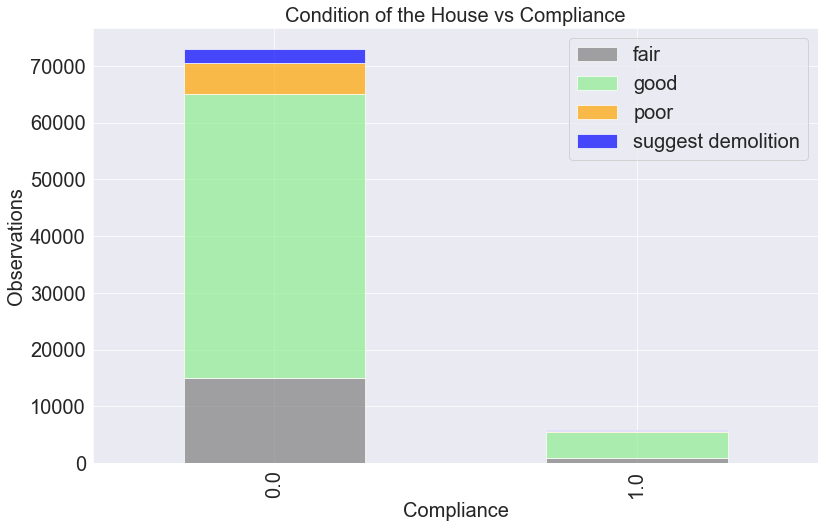

In [107]:
Condition_class = df.groupby(['compliance','Condition']).compliance.count().unstack()
p1 = Condition_class.plot(kind = 'bar', stacked = True, 
                          color = ['grey','lightgreen','orange','blue'], alpha = .70,
                          figsize=[13,8],
                         fontsize=20)
p1.set_xlabel('Compliance',fontsize=20)
p1.set_ylabel('Observations',fontsize=20)
plt.title('Condition of the House vs Compliance',fontsize=20)
plt.legend(['fair','good','poor','suggest demolition'],fontsize=20)
plt.savefig('images/Condition_compliance.png')
plt.show()


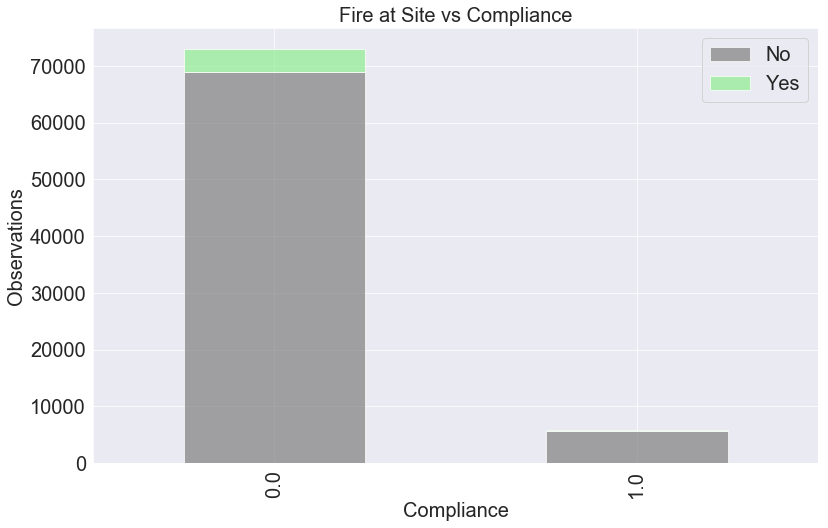

In [108]:
#print(df.groupby(['compliance','Fire']).Fire.count().unstack())

#Fire class visualization
Fire_class = df.groupby(['compliance','Fire']).compliance.count().unstack()
p1 = Fire_class.plot(kind = 'bar', stacked = True, 
                   color = ['grey','lightgreen',], alpha = .70, 
                     figsize=[13,8],
                    fontsize=20)
p1.set_xlabel('Compliance',fontsize=20)
p1.set_ylabel('Observations',fontsize=20)
plt.title('Fire at Site vs Compliance',fontsize=20)
plt.legend(['No','Yes'],fontsize=20)
plt.savefig('images/Fire_Compliance.png')
plt.show()


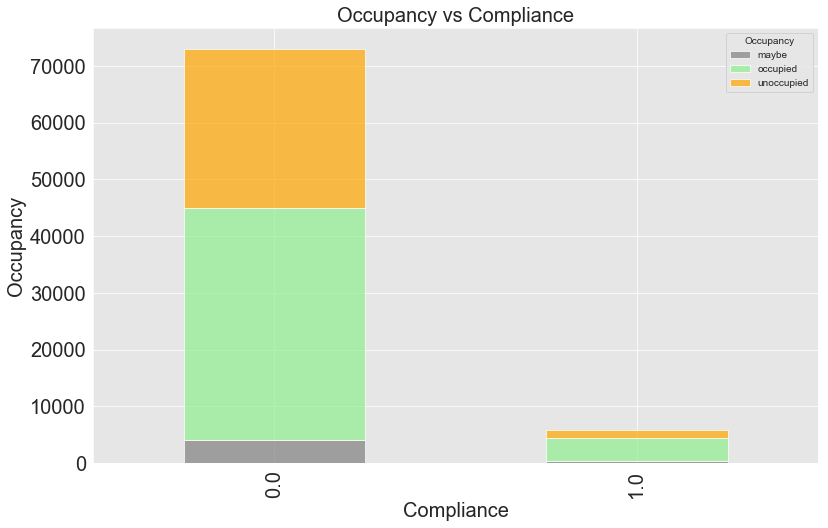

In [89]:

#print(df.groupby(['compliance','Occupancy']).compliance.count().unstack())

#Condition class visualization
Occupancy_class = df.groupby(['compliance','Occupancy']).compliance.count().unstack()
p1 = Occupancy_class.plot(kind = 'bar', stacked = True, 
                   color = ['grey','lightgreen','orange'], alpha = .70,
                          figsize=[13,8],
                         fontsize=20)
p1.set_xlabel('Compliance',fontsize=20)
p1.set_ylabel('Occupancy',fontsize=20)
plt.title( 'Occupancy vs Compliance',fontsize=20)

plt.savefig('images/Occupancy_vs_compliance.png')
plt.show()

In [123]:
df['crime_cat'] =df['crime_count'].map(lambda x: 0 if x<=2 else 1)

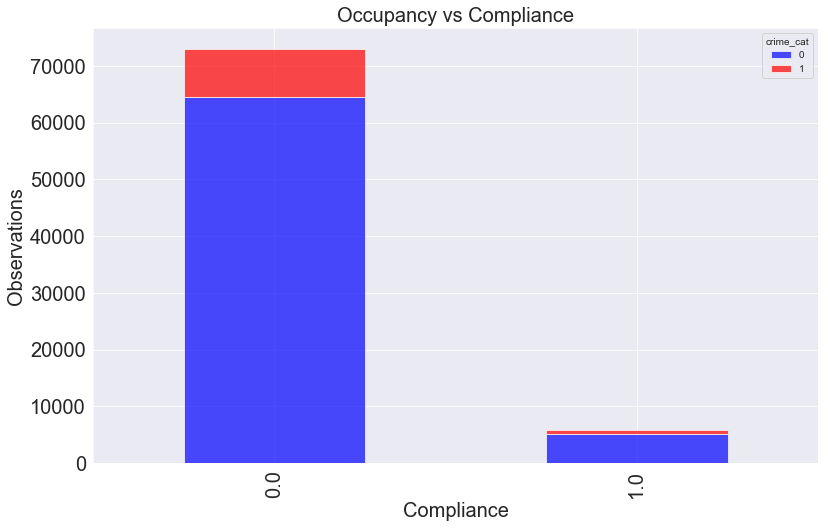

In [125]:

#print(df.groupby(['compliance','Occupancy']).compliance.count().unstack())

#Condition class visualization
Occupancy_class = df.groupby(['compliance','crime_cat']).compliance.count().unstack()
p1 = Occupancy_class.plot(kind = 'bar', stacked = True, 
                   color = ['blue', 'red'], alpha = .70,
                          figsize=[13,8],
                         fontsize=20)
p1.set_xlabel('Compliance',fontsize=20)
p1.set_ylabel('Observations',fontsize=20)
plt.title( 'Occupancy vs Compliance',fontsize=20)

plt.savefig('images/Occupancy_vs_compliance.png')
plt.show()

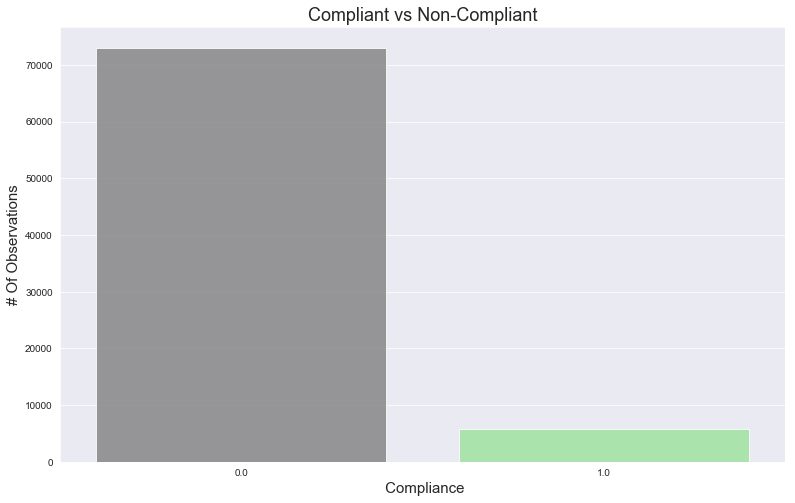

In [127]:
# Target Variable Countplot
sns.set_style('darkgrid')
plt.figure(figsize = (13,8))
sns.countplot(target, alpha =.80, palette= ['grey','lightgreen'])
plt.title('Compliant vs Non-Compliant', size = 18)
plt.ylabel('# Of Observations', size =15)
plt.xlabel(' Compliance', size =15)
plt.show()

In [9]:
#  Creating dummy variables for categorical variables wit function to_dummies.
X = to_dummies(df[features], cat_features)
y = target

## Create Model and Define Evaluation Metric for Project

-----

## Logistic Regression Model 

In [10]:
log_clf = log_reg(X, y)

Accuracy on Train Set:
0.9274271310879164

 Accuracy on Test Set: 
0.9264146155798021

 Confusion Matrix for Test Set
[[18232    15]
 [ 1435    23]]

 General Repor 

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     18247
         1.0       0.61      0.02      0.03      1458

    accuracy                           0.93     19705
   macro avg       0.77      0.51      0.50     19705
weighted avg       0.90      0.93      0.89     19705



------------
## Logistic Regression Model WITH SMOTE

In [11]:
log_reg_smote(X, y)

Original class distribution
0.0    73057
1.0     5761
Name: compliance, dtype: int64

 Synthetic sample class distribution
1.0    54810
0.0    54810
Name: compliance, dtype: int64
----------------------------------------

 Accuracy on Train Set:
0.8307140561297853

 Accuracy on Test Set:
0.8298908906368941

 Confusion Matrix for Test Set

[[15534  2713]
 [  639   819]]

 General Repor: 

              precision    recall  f1-score   support

         0.0       0.96      0.85      0.90     18247
         1.0       0.23      0.56      0.33      1458

    accuracy                           0.83     19705
   macro avg       0.60      0.71      0.62     19705
weighted avg       0.91      0.83      0.86     19705



LogisticRegression(fit_intercept=False, solver='liblinear')

-----

## Regular Decision Tree Model 

In [12]:
dt = decision_tree(X, y)

Accuracy on Train Set:
0.9468571014282607

 Accuracy on Test Set: 
0.931954664636725

 F1 Score for Test Set:
0.30795698924731185

 Confusion Matrix for Test Set:
[[21679   225]
 [ 1384   358]]

 General Repor: 

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.96     21904
         1.0       0.61      0.21      0.31      1742

    accuracy                           0.93     23646
   macro avg       0.78      0.60      0.64     23646
weighted avg       0.92      0.93      0.92     23646



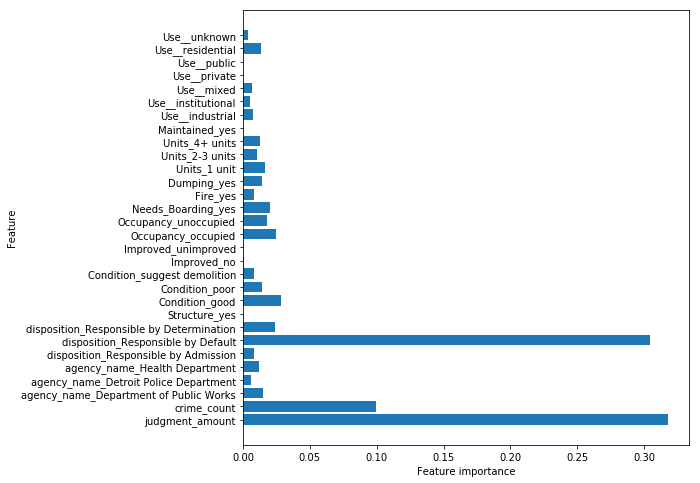

In [13]:
# Lets take a look at features Importance
plot_feature_importances(dt, X)

---------
## Descision Tree Model with SMOTE

In [14]:
dt_smote = decision_tree_smote(X , y , max_depth = None)

Accuracy on Train Set:
0.8536214021605162

 Accuracy on Test Set: 
0.832022329358031
----

 Confusion Matrix for Test Set
[[18726  3178]
 [  794   948]]

 General Repor 

              precision    recall  f1-score   support

         0.0       0.96      0.85      0.90     21904
         1.0       0.23      0.54      0.32      1742

    accuracy                           0.83     23646
   macro avg       0.59      0.70      0.61     23646
weighted avg       0.91      0.83      0.86     23646



---------

## Randome Forest Model

In [15]:
forest = randome_forest(X, y)

Accuracy on Train Set:
0.9457514681360111

 Accuracy on Test Set: 
0.9462488370126025

 Confusion Matrix for Test Set
[[21836    68]
 [ 1203   539]]

 General Repor :

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97     21904
         1.0       0.89      0.31      0.46      1742

    accuracy                           0.95     23646
   macro avg       0.92      0.65      0.72     23646
weighted avg       0.94      0.95      0.93     23646



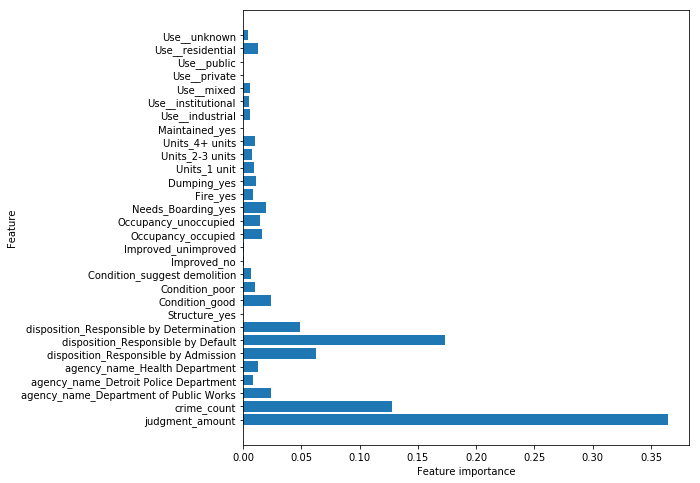

In [16]:
plot_feature_importances(forest, X)

## AdaBoost Gradient Boosting and Weak Learners

In [23]:
ada_clf = AdaBoost(X, y)

Accuracy on Train Set:
0.9291357231065924

 Accuracy on Test Set: 
0.9277340776452677

 Confusion Matrix for Test Set
[[18194    53]
 [ 1371    87]]

 General Repor :

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     18247
         1.0       0.62      0.06      0.11      1458

    accuracy                           0.93     19705
   macro avg       0.78      0.53      0.54     19705
weighted avg       0.91      0.93      0.90     19705



-----

##  Gradient Boostin Clasifier

In [24]:
gbt_clf = gbt(X, y)

Accuracy on Train Set:
0.9371880973728283

 Accuracy on Test Set: 
0.9360568383658969

 Confusion Matrix for Test Set
[[18226    21]
 [ 1239   219]]

 General Repor :

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     18247
         1.0       0.91      0.15      0.26      1458

    accuracy                           0.94     19705
   macro avg       0.92      0.57      0.61     19705
weighted avg       0.93      0.94      0.91     19705



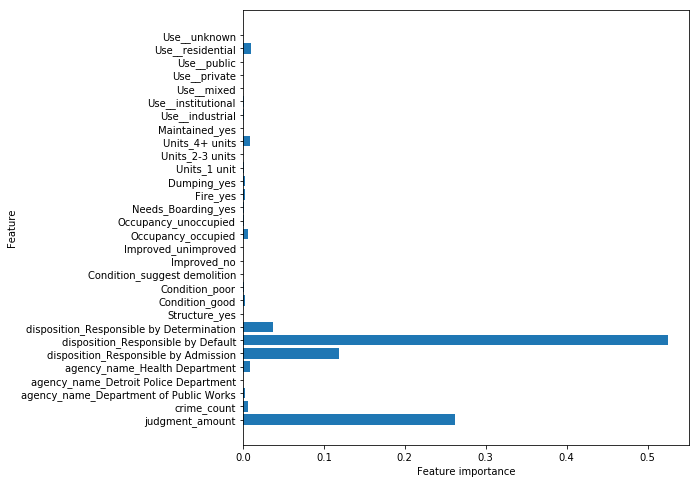

In [25]:
plot_feature_importances(gbt_clf, X)

-----------

## Using Grid Search for Tunning Gradient Boostin Clasifier

Combining K-Fold Cross-Validation with a grid search of parameters. In order to do this, we must first create a parameter grid that tells sklearn which parameters to tune, and which values to try for each of those parameters.

In [51]:
dt_param_grid = { 'max_depth': [None, 2, 3] }

In [52]:
# Instantiate GridSearchCV
dt_grid_search = GridSearchCV(gbt_clf, dt_param_grid, cv=3, scoring = 'precision')

# Fit to the data
dt_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=42),
             param_grid={'max_depth': [None, 2, 3]}, scoring='precision')

In [53]:
dt_grid_search.best_params_

{'max_depth': 2}

In [61]:
gbt_best = gbt(X, y, max_depth = 2)

Accuracy on Train Set:
0.9306074805880263

 Accuracy on Test Set: 
0.9302207561532606

 Confusion Matrix for Test Set
[[18243     4]
 [ 1371    87]]

 General Repor :

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     18247
         1.0       0.96      0.06      0.11      1458

    accuracy                           0.93     19705
   macro avg       0.94      0.53      0.54     19705
weighted avg       0.93      0.93      0.90     19705



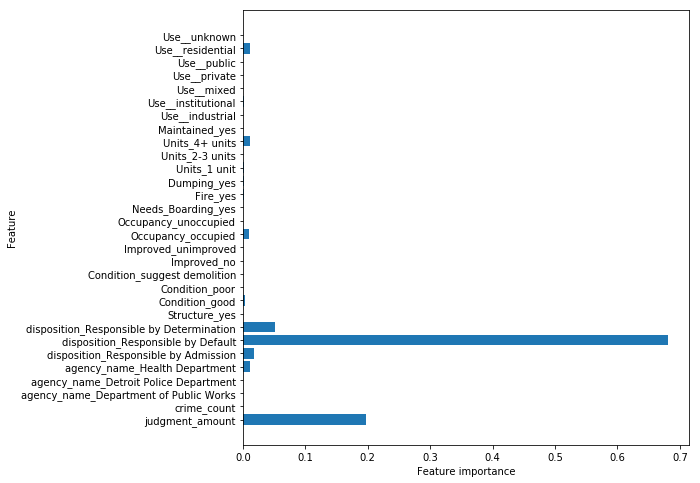

In [62]:
plot_feature_importances(gbt_best, X)

Accuracy on Train Set:
0.9306074805880263

 Accuracy on Test Set: 
0.9302207561532606

 Confusion Matrix for Test Set
[[18243     4]
 [ 1371    87]]

 General Repor :

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     18247
         1.0       0.96      0.06      0.11      1458

    accuracy                           0.93     19705
   macro avg       0.94      0.53      0.54     19705
weighted avg       0.93      0.93      0.90     19705

AUC: 0.7941654426084133


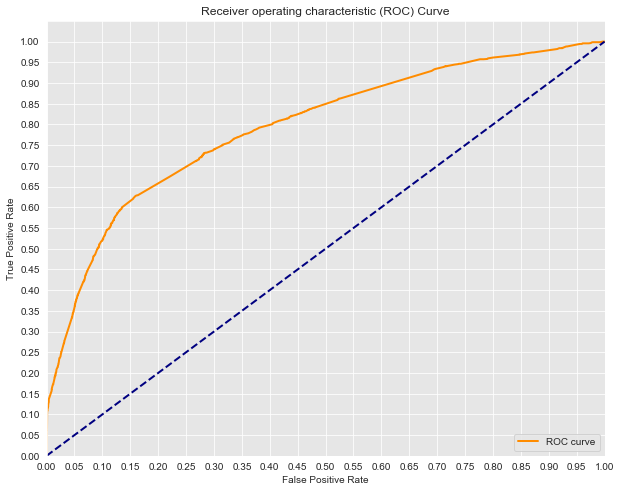

In [68]:
gbt_best = gbt(X, y, max_depth = 2, show_roc= True)